In [55]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

from scipy.signal import hilbert

import pandas as pd

import sys
import os

#get current directory (the directory where this notebook is located)
cdir = os.getcwd()

#get the grandmother directory (two levels up)
grandma_dir = os.path.abspath(os.path.join(cdir, os.pardir, os.pardir))

# Construct the path to the py directory
py_dir = os.path.join(grandma_dir, 'py')

for dir in [py_dir]:
    #include function-directories to the system path
    if dir not in sys.path:
        sys.path.append(dir)
        print(f"Included {dir} in sys.path")

#verify  directories
print(f"Current directory: {cdir}")
print(f"Grandmother directory: {grandma_dir}")
print(f"System path: {sys.path}")


import continuum1d as continuum1d
c1d = continuum1d.continuum1d()

from params import setParams
from analysis import computeFPs, checkFixPtsStability, violationType, a_jkValues, lmbd
from turings import checkStability
from funcs import getSwitchIndex

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

1d Model initialised.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def rotation_in_latency(array):
    """This function determines, based on the phase latency, into which direction the traveling waves rotate.
    INPUT:
    :array: numpy array, 1-dimensional, consists of the phase latency 
            ('how many time steps it takes node to cross the threshold 2\pi') per node (i.e. dim(array)=params.n)
            
    OUTPUT:
    :rotation: -1 (clockwise), or +1 (counterclockwise)
    """
    
    max_arg = np.argmax(array)
    argmax_before = max_arg-1
    argmax_after = max_arg+1
    if argmax_after == len(array):
        argmax_after=0
    diff_to_left = np.abs(array[max_arg]-array[int(argmax_before)])
    diff_to_right = np.abs(array[max_arg]-array[int(argmax_after)])
    
    if diff_to_left>diff_to_right:
        rotation = +1 #"counterclockwise"
    else:
        rotation = -1 #"clockwise"

    return rotation

def count_nodes_for_descent(array, rotation):
    """This function determines the amount of nodes that are necessary for one full phase transition from max to min
    i.e. how many nodes are necessary for one full phase
    INPUT: 
    :array: numpy array, 1-dimensional, consists of the phase latency 
            ('how many time steps it takes node to cross the threshold 2\pi') per node (i.e. dim(array)=params.n)
    :rotation: identifies in which direction we have to descent to count until next max
    
    OUTPUT:
    :count: amount of nodes that are necessary until the next full phase transition starts
    """
    
    max_arg = np.argmax(array)
    
    count = 0
    node = max_arg
    if rotation<0:
        while array[node-1] < array[node]:
            count += 1
            node -= 1
            node = int(node)
            if node >= len(array)-1:
                node = 0
    else:
        while array[node+1] < array[node]:
            count += 1
            node += 1
            node = int(node)
            if node >= len(array)-1:
                node = 0
            
    
    return count

In [3]:
def hilbert_trafo_nd(signal, axis=0):
    """simply the call of the off-shelf implementation to not have to calculate it for every feature individually.
    INPUT:
    :signal: (n,m)-dimensional array of real-valued signal. 
    We have activity=(rows,columns)=(time,nodes) -> default-axis=0.
    
    :output: (n,m)-dimensional array analytical representation of signal
    """
    from scipy.signal import hilbert
    
    #compute Hilbert Transform for analytical signal representation
    #ue.shape = (time-steps+1, number of nodes)
    #i.e. rows=time, columns=node -> want hilbert trafo w.r.t. time => axis=0
    ana_signal = hilbert(signal, axis=axis)
    
    return(ana_signal)

def hilbert_trafo_1d(signal):
    """simply the call of the off-shelf implementation to not have to calculate it for every feature individually"""
    from scipy.signal import hilbert
    
    ana_signal = hilbert(signal)
    
    return(ana_signal)

def inst_phase(signal):
    """Compute the instantaneous phase per time step per node."""
    
    #without unwrapping?
    inst_phase = np.unwrap(np.angle(signal))
    
    #inst_phase = np.unwrap(np.angle(signal))
    
    return inst_phase

def inst_frequ(signal):
    """ This function is supposed to determine the instantaneous frequency of a real-valued signal. 
    We use the method from Muller et al (2014), DOI: 10.1038/ncomms4675.
    
    INPUT:
    :signal: analytical representation (a+ib) of real-valued times series, 1-dimensional, array
    
    :output: instantaneous frequency without phase unwrapping, array"""
    
    
    #compute Hilbert Transform for analytical signal representation
    #ue.shape = (time-steps+1, number of nodes)
    #i.e. rows=time, columns=node -> want hilbert trafo w.r.t. time => axis=0
   # ana_signal = hilbert(signal)#, axis=0)
    
    complex_conj = np.conj(signal)
    #roll complex conjugate s.t. in product we compute 
    #(X_n\cdotX^*_{n+1} i.e. we multiply the analytical representation of signal 
    #at space step n with the complex conjugate of the next space step n+1)
    complex_conj = np.roll(complex_conj, -1)
    
    #use elementwise multiplication
    inst_frequ_temp = np.angle(np.multiply(signal, complex_conj))
    
    #omit last one, since it would be the product of X_n\cdotX^*_0
    inst_frequ = inst_frequ_temp[:-1]
    
    return inst_frequ
    

# explicit function to normalize array (for visualisation reasons - very helpful!)
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

In [53]:
fs = 20
dpi = 160
time_labels = np.linspace(0,8,9)
space_labels = np.linspace(-25,25,5)

In [4]:
ee = -0.3
ii = -0.75

params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 15*1000, 'mu_a': 0.4, 'beta_a': 10, 'n': 526}

ps = setParams(params)
fps = computeFPs(ps)
stab = checkFixPtsStability(fps, ps)

k=np.linspace(-3,3,51)

a_ee, a_ei, a_ie, a_ii = a_jkValues(fps[-1], ps)

print('fixed points %s ' %str(fps))
print('with (mass) stability %s'  %str(stab))

fp = fps[0]
checkStability(k, fp, ps)

fixed points [[0.22389562 0.24170095]] 
with (mass) stability [0]


(1, 1, 0)

In [5]:
ue_fast, ui = c1d.run(ps, itype='inte_adaptation', fp=fp)

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3388/92647775.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=time_labels, fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3388/92647775.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=space_labels, fontsize=fs)


[Text(1, 0.0, '0'),
 Text(1, 0.3333333333333333, '0.33'),
 Text(1, 0.6666666666666666, '0.66'),
 Text(1, 1.0, '1')]

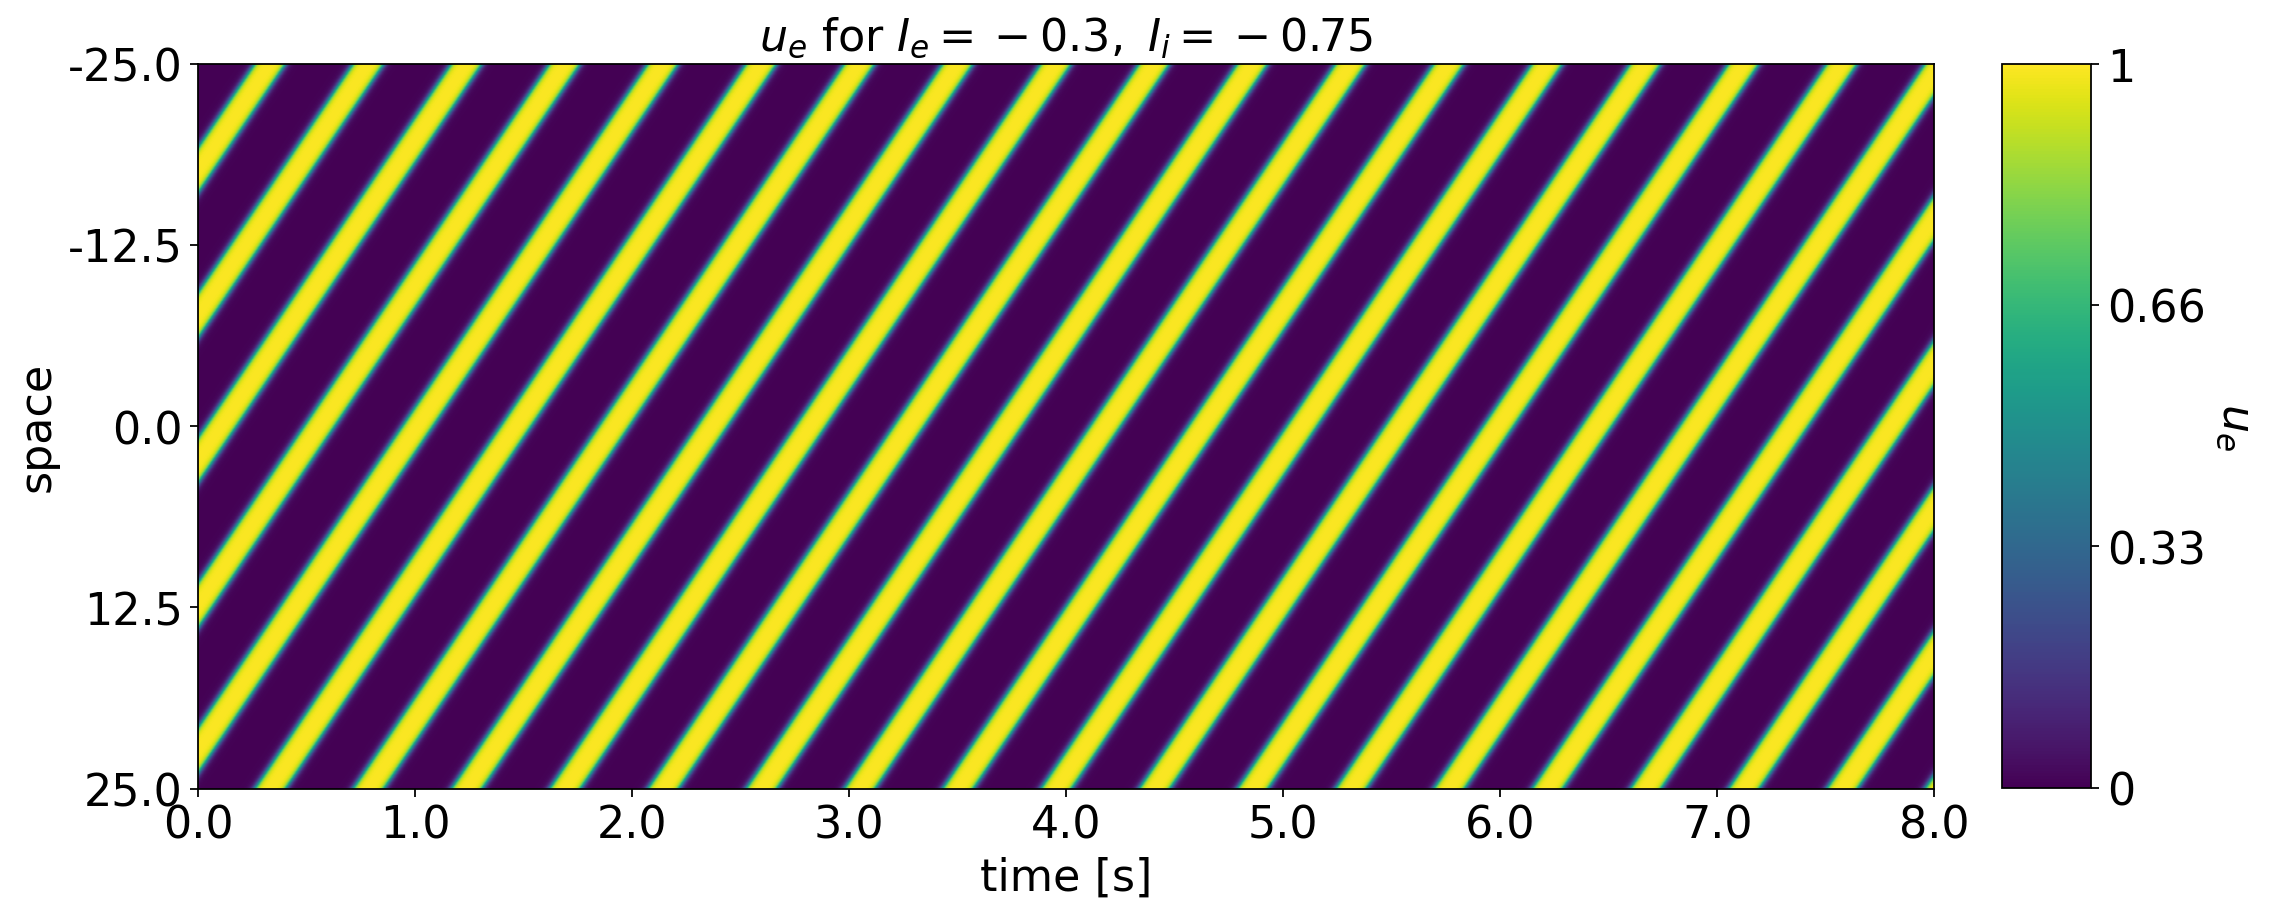

In [83]:
cmap = 'viridis'
fig, ax = plt.subplots(1, 1, figsize=(14,6), dpi=dpi)

pos = ax.imshow(ue_fast.T[:,-80000:], vmin=0, vmax=1, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

#ax.scatter(fast_max, -fast_rotation*fast_count, s=20, color='black')

ax.set_title(label=r'$u_e$' + ' for ' + r'$I_e=-0.3,\ I_i=-0.75$', fontsize=fs)


#set x-axis labels
ax.set_xlabel('time [s]', fontsize=fs)
ax.xaxis.set_major_locator(ticker.LinearLocator(len(time_labels)))
ax.set_xticklabels(labels=time_labels, fontsize=fs)

#set y-axis labels
ax.set_ylabel('space', fontsize=fs)
ax.yaxis.set_major_locator(ticker.LinearLocator(len(space_labels)))
ax.set_yticklabels(labels=space_labels, fontsize=fs)

cbar_ticks=np.linspace(0,1,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom", fontsize=fs)
cbar.ax.set_yticklabels([0, 0.33, 0.66, 1], fontsize=fs)

In [60]:
duration = 10
dur_steps = int(duration * (1/ps.dt) * 1000)
signal = hilbert_trafo_nd(ue_fast[-dur_steps:,:], axis=0)
phases_fast = inst_phase(signal)

In [61]:
phases_fast_cut = phases_fast[-80000:]
len(phases_fast_cut.T)

526

In [62]:
fast_phase_latencies = np.zeros(len(phases_fast_cut.T))

for idx, node in enumerate(phases_fast_cut.T):
    complex_vector = np.exp(1j * node)
    
    # Extract real and imaginary components of the complex vectors
    real_part = np.real(complex_vector)
    imaginary_part = np.imag(complex_vector)
    
    how_many_time_steps = getSwitchIndex(imaginary_part)
    #print(how_many_time_steps[0])
    fast_phase_latencies[idx] = how_many_time_steps[0]

In [63]:
# assign array and range
array_1d = fast_phase_latencies
range_to_normalize = (0, 1)
fast_phase_latencies_norm = normalize(array_1d, range_to_normalize[0], range_to_normalize[1])

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3388/3385425014.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=space_labels, fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3388/3385425014.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=np.linspace(0, max(fast_phase_latencies), 5).astype(int), fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3388/3385425014.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


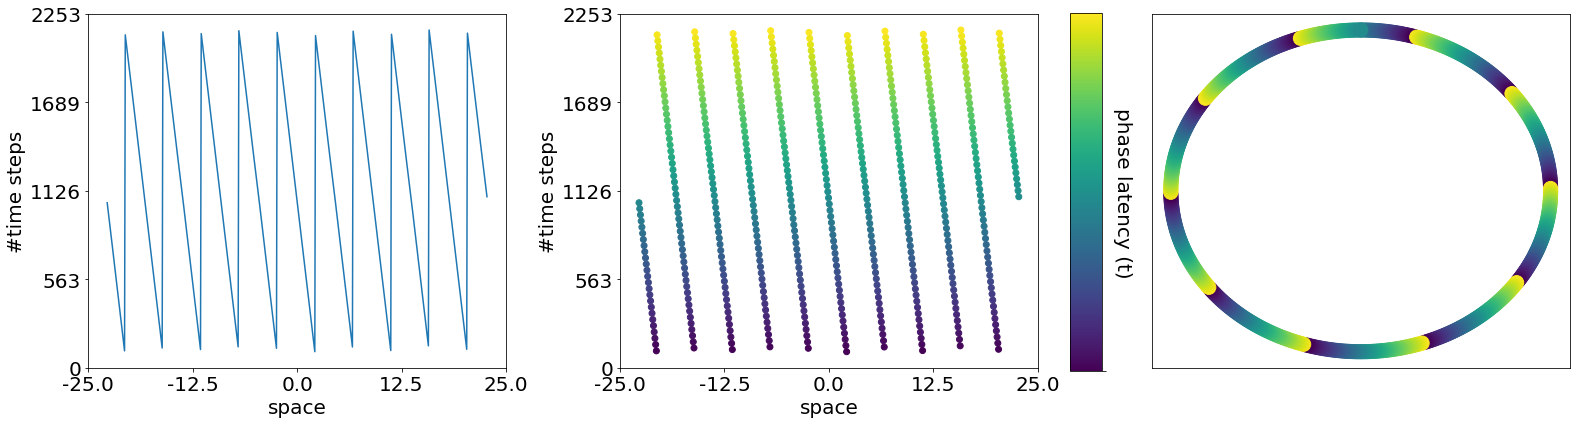

In [81]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(22,6))


ax0.plot(fast_phase_latencies)

ax1.scatter(np.linspace(0,ps.n-1, ps.n), fast_phase_latencies, c=fast_phase_latencies_norm)

pos = ax2.scatter(np.sin(np.linspace(0,2*np.pi, ps.n)),np.cos(np.linspace(0,2*np.pi, ps.n)), c=fast_phase_latencies_norm,
            s=200)


for ax in [ax0, ax1]:
    #set x-axis labels
    ax.set_xlabel('space', fontsize=fs)
    ax.xaxis.set_major_locator(ticker.LinearLocator(len(space_labels)))
    ax.set_xticklabels(labels=space_labels, fontsize=fs)
    
    #set y-axis labels
    ax.set_ylabel('#time steps', fontsize=fs)
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_yticklabels(labels=np.linspace(0, max(fast_phase_latencies), 5).astype(int), fontsize=fs)
    
ax2.set_xlabel('')
ax2.xaxis.set_major_locator(ticker.LinearLocator(0))
ax2.set_xticklabels(labels=[])  
    
ax2.set_ylabel('')
ax2.yaxis.set_major_locator(ticker.LinearLocator(0))
ax2.set_yticklabels(labels=[])    

cbar_ticks=np.linspace(0,max(fast_phase_latencies),4)
cb_ax = fig.add_axes([.678,.130,.02,.830])
cbar = ax.figure.colorbar(pos, ax=ax2, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel('phase latency (t)', rotation=-90, va="bottom", fontsize=fs)
cbar.ax.set_yticklabels([])

plt.tight_layout()

In [11]:
fast_rotation = rotation_in_latency(fast_phase_latencies)
fast_count = count_nodes_for_descent(fast_phase_latencies, fast_rotation)
fast_count, fast_rotation

(52, 1)

In [27]:
ee = 0.85
ii = 0.27

params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 25*1000, 'mu_a': 0.4, 'beta_a': 10, 'n': 526, 'tau_a': 6000}

ps = setParams(params)
fps = computeFPs(ps)
stab = checkFixPtsStability(fps, ps)

k=np.linspace(-3,3,51)

a_ee, a_ei, a_ie, a_ii = a_jkValues(fps[-1], ps)

print('fixed points %s ' %str(fps))
print('with (mass) stability %s'  %str(stab))

fp = fps[0]
checkStability(k, fp, ps)

fixed points [[0.11764133 0.62131853]
 [0.6610546  0.99957344]
 [0.99743213 0.99999834]] 
with (mass) stability [1, 0, 1]


(1, 1, 0)

In [28]:
ue_slow, ui = c1d.run(ps, itype='inte_adaptation', fp=fp)

Text(0, 0.5, 'space')

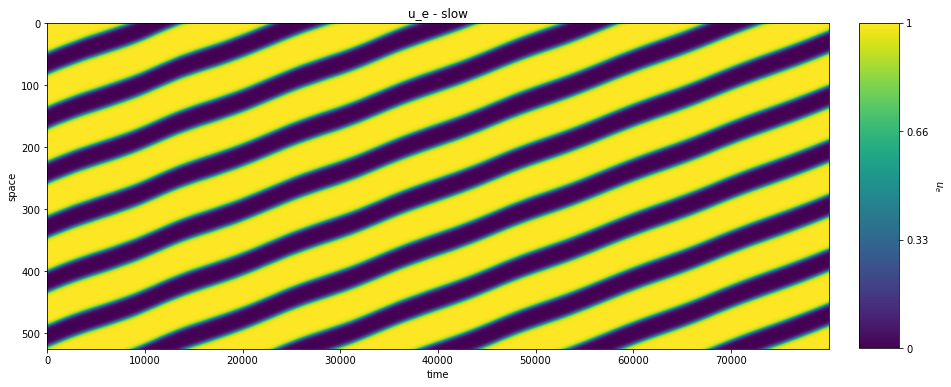

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

pos = ax.imshow(ue_slow.T[:,-80000:], vmin=0, vmax=1, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

#ax.scatter(slow_max, -slow_rotation*slow_count, s=20, color='black')

ax.set_title(label='u_e - slow')

cbar_ticks=np.linspace(0,1,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom")
cbar.ax.set_yticklabels([0, 0.33, 0.66, 1])

ax.set_xlabel('time')
ax.set_ylabel('space')

In [30]:
duration = 10
dur_steps = int(duration * (1/ps.dt) * 1000)
signal = hilbert_trafo_nd(ue_slow[-dur_steps:,:], axis=0)
slow_phases = inst_phase(signal)

In [31]:
slow_phases_cut = slow_phases[-80000:]
len(slow_phases_cut.T)

526

In [32]:
slow_phase_latencies = np.zeros(len(slow_phases_cut.T))

for idx, node in enumerate(slow_phases_cut.T):
    complex_vector = np.exp(1j * node)
    
    # Extract real and imaginary components of the complex vectors
    real_part = np.real(complex_vector)
    imaginary_part = np.imag(complex_vector)
    
    how_many_time_steps = getSwitchIndex(imaginary_part)
    #print(how_many_time_steps[0])
    slow_phase_latencies[idx] = how_many_time_steps[0]

In [33]:
# assign array and range
array_1d = slow_phase_latencies
range_to_normalize = (0, 1)
slow_phase_latencies_norm = normalize(array_1d, range_to_normalize[0], range_to_normalize[1])

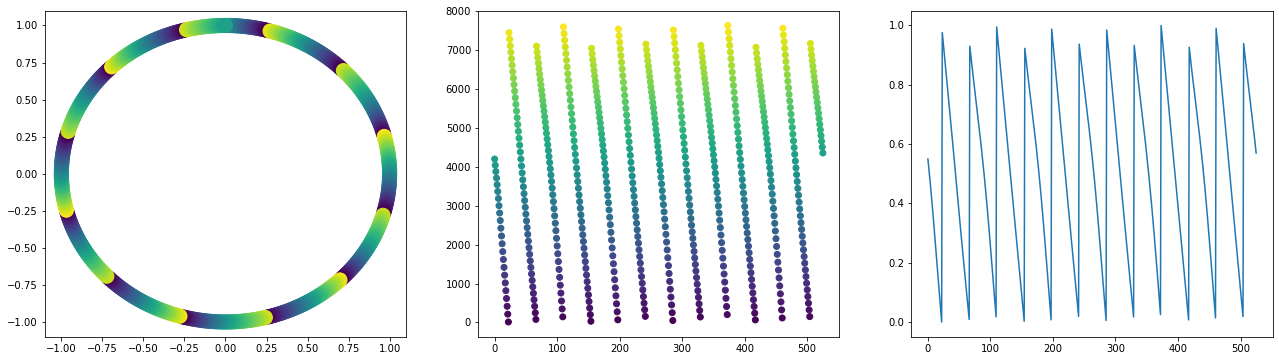

In [34]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(22,6))

ax0.scatter(np.sin(np.linspace(0,2*np.pi, ps.n)),np.cos(np.linspace(0,2*np.pi, ps.n)), c=slow_phase_latencies_norm,
            s=200)

ax1.scatter(np.linspace(0,ps.n-1, ps.n), slow_phase_latencies, c=slow_phase_latencies_norm)

ax2.plot(slow_phase_latencies_norm)

In [35]:
slow_rotation = rotation_in_latency(slow_phase_latencies)
slow_count = count_nodes_for_descent(slow_phase_latencies, slow_rotation)
slow_count, slow_rotation

(44, 1)

In [46]:
ee = 0.85
ii = 0.27

params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 25*1000, 'mu_a': 0.4, 'beta_a': 10, 'n': 526, 'tau_a': 600}

ps = setParams(params)
fps = computeFPs(ps)
stab = checkFixPtsStability(fps, ps)

k=np.linspace(-3,3,51)

a_ee, a_ei, a_ie, a_ii = a_jkValues(fps[-1], ps)

print('fixed points %s ' %str(fps))
print('with (mass) stability %s'  %str(stab))

fp = fps[0]
checkStability(k, fp, ps)

fixed points [[0.11764133 0.62131853]
 [0.6610546  0.99957344]
 [0.99743213 0.99999834]] 
with (mass) stability [1, 0, 1]


(1, 1, 0)

In [50]:
ue_lower, ui = c1d.run(ps, itype='inte_adaptation', fp=fp)

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3388/2636942716.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=time_labels, fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3388/2636942716.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=space_labels, fontsize=fs)


[Text(1, 0.0, '0'),
 Text(1, 0.3333333333333333, '0.33'),
 Text(1, 0.6666666666666666, '0.66'),
 Text(1, 1.0, '1')]

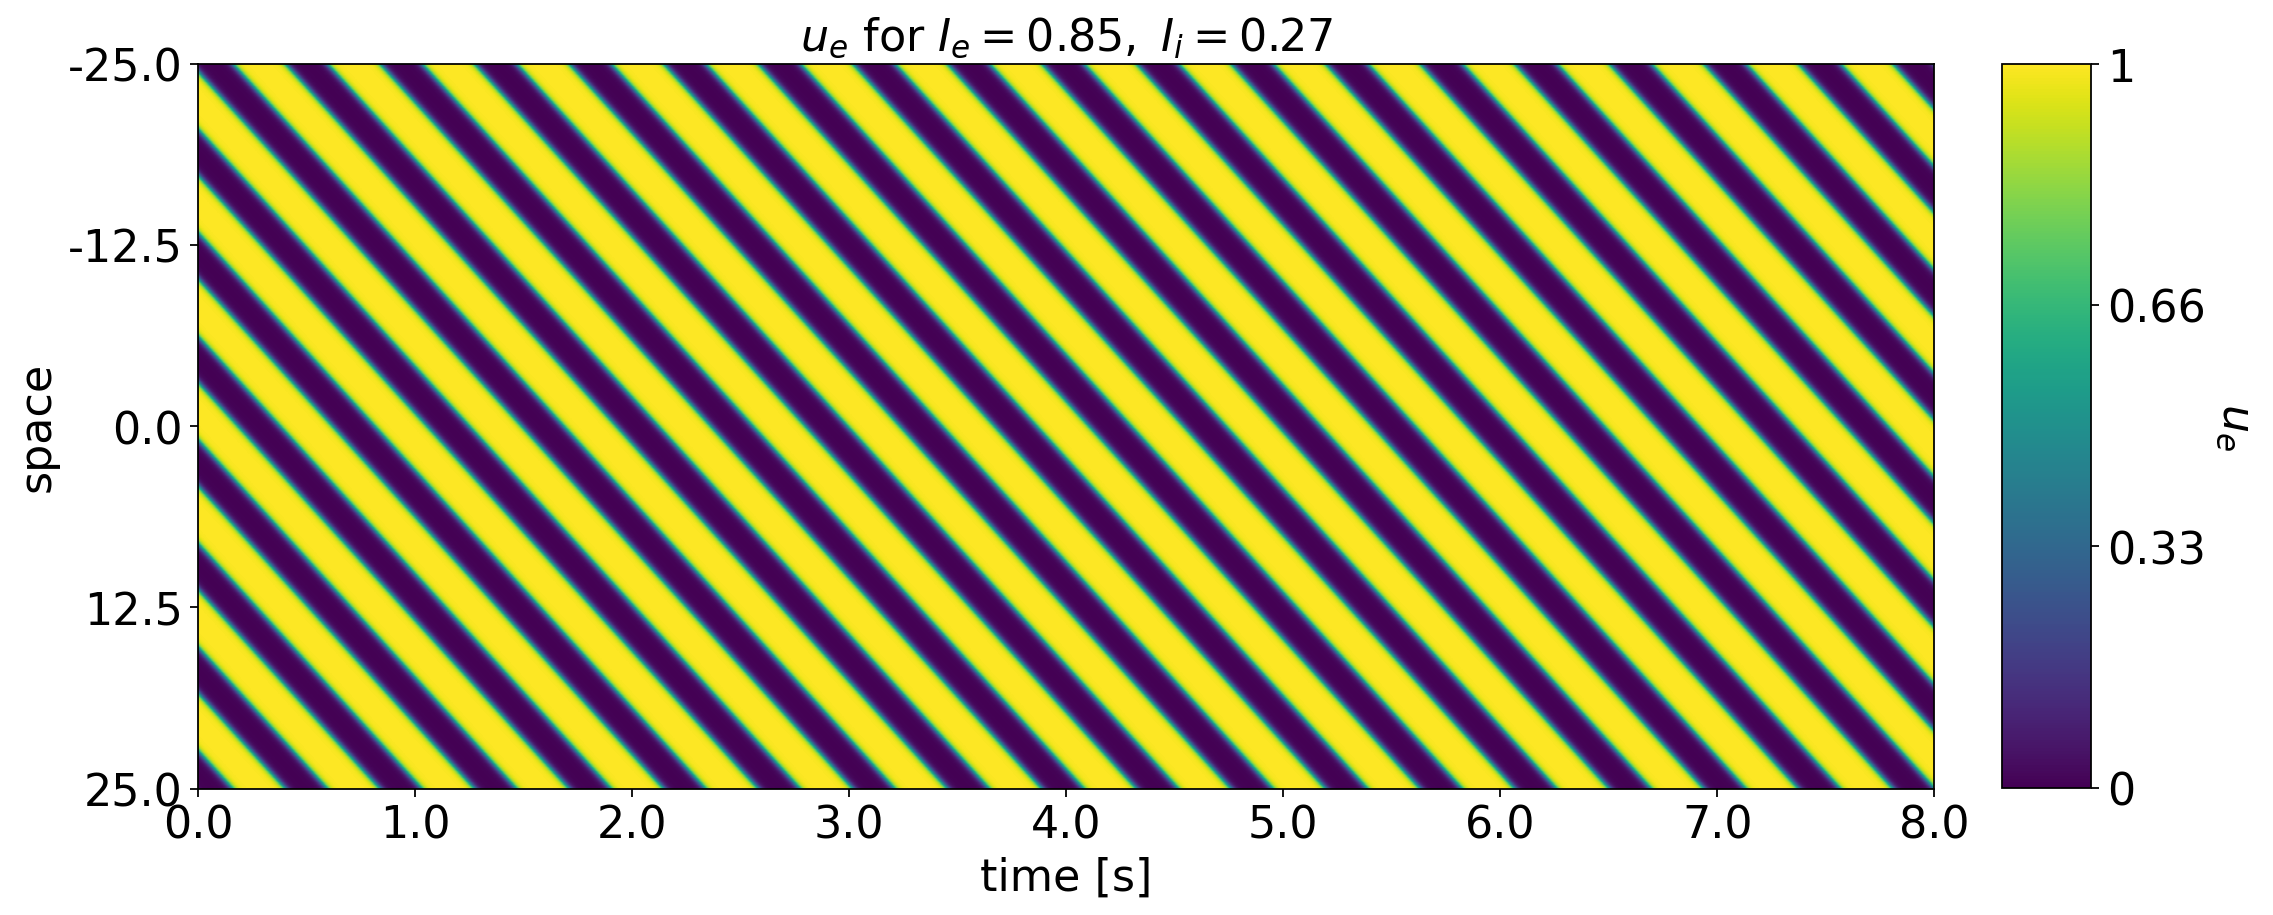

In [82]:
cmap = 'viridis'
fig, ax = plt.subplots(1, 1, figsize=(14,6), dpi=dpi)

pos = ax.imshow(ue_lower.T[:,-80000:], vmin=0, vmax=1, aspect='auto', cmap=cmap)
colors = ['black', 'dimgray', 'silver']

#ax.scatter(fast_max, -fast_rotation*fast_count, s=20, color='black')

ax.set_title(label=r'$u_e$' + ' for ' + r'$I_e=0.85,\ I_i=0.27$', fontsize=fs)


#set x-axis labels
ax.set_xlabel('time [s]', fontsize=fs)
ax.xaxis.set_major_locator(ticker.LinearLocator(len(time_labels)))
ax.set_xticklabels(labels=time_labels, fontsize=fs)

#set y-axis labels
ax.set_ylabel('space', fontsize=fs)
ax.yaxis.set_major_locator(ticker.LinearLocator(len(space_labels)))
ax.set_yticklabels(labels=space_labels, fontsize=fs)

cbar_ticks=np.linspace(0,1,4)
cb_ax = fig.add_axes([.93,.126,.04,.754])
cbar = ax.figure.colorbar(pos, ax=ax, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel(r'$u_e$', rotation=-90, va="bottom", fontsize=fs)
cbar.ax.set_yticklabels([0, 0.33, 0.66, 1], fontsize=fs)

In [39]:
duration = 10
dur_steps = int(duration * (1/ps.dt) * 1000)
signal = hilbert_trafo_nd(ue_lower[-dur_steps:,:], axis=0)
lower_phases = inst_phase(signal)

In [40]:
lower_phases_cut = lower_phases[-80000:]
len(lower_phases_cut.T), len(lower_phases_cut)
lower_phases_cut.T[0]

array([ 0.01863834,  0.01932566,  0.01998584, ..., -1.56814924,
       -1.56815505, -1.56901186])

In [41]:
lower_phase_latencies = np.zeros(len(lower_phases_cut.T))

for idx, node in enumerate(lower_phases_cut.T):
    complex_vector = np.exp(1j * node)
    
    # Extract real and imaginary components of the complex vectors
    real_part = np.real(complex_vector)
    imaginary_part = np.imag(complex_vector)
    
    how_many_time_steps = getSwitchIndex(imaginary_part)
    #print(how_many_time_steps[0])
    lower_phase_latencies[idx] = how_many_time_steps[0]

In [42]:
# assign array and range
array_1d = lower_phase_latencies
range_to_normalize = (0, 1)
lower_phase_latencies_norm = normalize(array_1d, range_to_normalize[0], range_to_normalize[1])

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3388/953606132.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=space_labels, fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3388/953606132.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=np.linspace(0, max(fast_phase_latencies), 5).astype(int), fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_3388/953606132.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


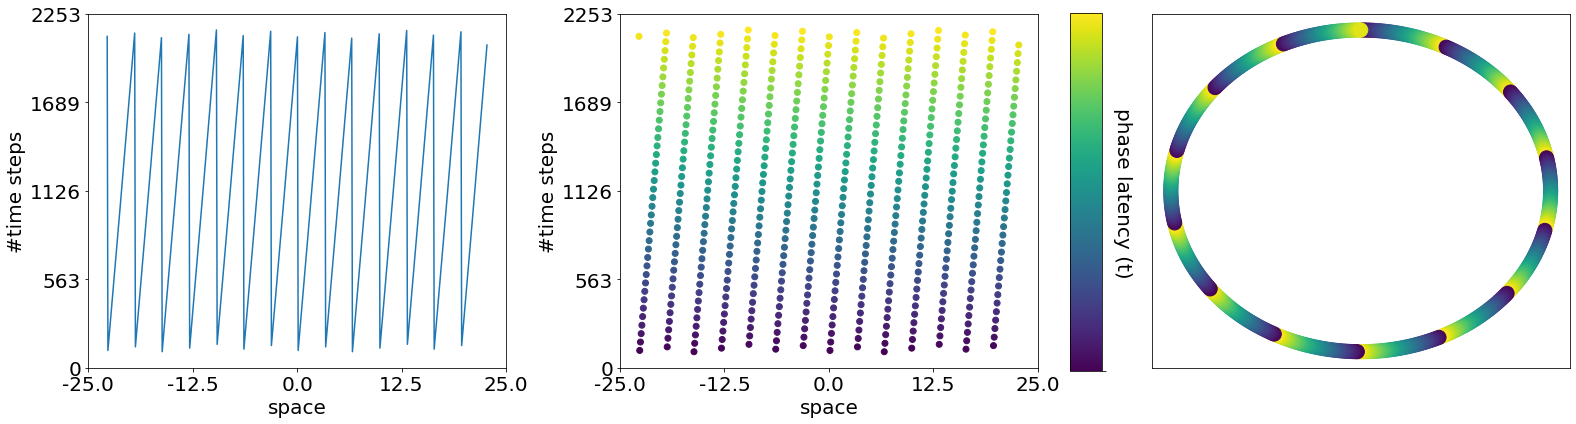

In [84]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(22,6))


ax0.plot(lower_phase_latencies)

ax1.scatter(np.linspace(0,ps.n-1, ps.n), lower_phase_latencies, c=lower_phase_latencies_norm)

pos = ax2.scatter(np.sin(np.linspace(0,2*np.pi, ps.n)),np.cos(np.linspace(0,2*np.pi, ps.n)), c=lower_phase_latencies_norm,
            s=200)


for ax in [ax0, ax1]:
    #set x-axis labels
    ax.set_xlabel('space', fontsize=fs)
    ax.xaxis.set_major_locator(ticker.LinearLocator(len(space_labels)))
    ax.set_xticklabels(labels=space_labels, fontsize=fs)
    
    #set y-axis labels
    ax.set_ylabel('#time steps', fontsize=fs)
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_yticklabels(labels=np.linspace(0, max(fast_phase_latencies), 5).astype(int), fontsize=fs)
    
ax2.set_xlabel('')
ax2.xaxis.set_major_locator(ticker.LinearLocator(0))
ax2.set_xticklabels(labels=[])  
    
ax2.set_ylabel('')
ax2.yaxis.set_major_locator(ticker.LinearLocator(0))
ax2.set_yticklabels(labels=[])    

cbar_ticks=np.linspace(0,max(fast_phase_latencies),4)
cb_ax = fig.add_axes([.678,.130,.02,.830])
cbar = ax.figure.colorbar(pos, ax=ax2, ticks=cbar_ticks, cax=cb_ax)
cbar.ax.set_ylabel('phase latency (t)', rotation=-90, va="bottom", fontsize=fs)
cbar.ax.set_yticklabels([])

plt.tight_layout()

In [44]:
lower_rotation = rotation_in_latency(lower_phase_latencies)
lower_count = count_nodes_for_descent(lower_phase_latencies, lower_rotation)
lower_count, lower_rotation

(37, -1)

In [45]:
fast_max = fast_phase_latencies[np.argmax(fast_phase_latencies)]
slow_max = slow_phase_latencies[np.argmax(slow_phase_latencies)]
lower_max = lower_phase_latencies[np.argmax(lower_phase_latencies)]

(-60.0, 40.0)

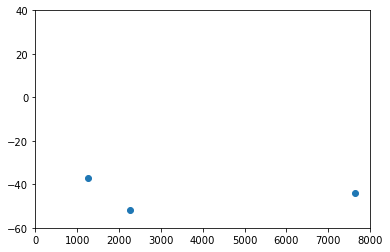

In [31]:
plt.scatter([fast_max, slow_max, lower_max], [fast_rotation*fast_count, 
                                              slow_rotation*slow_count, 
                                              lower_rotation*lower_count])
plt.xlim([0,8000])
plt.ylim([-60,40])

In [32]:
fast_argmax = np.argmax(fast_phase_latencies)
slow_argmax = np.argmax(slow_phase_latencies)
lower_argmax = np.argmax(lower_phase_latencies)

In [33]:
fast_distance = ps.x[0]-ps.x[fast_argmax]
slow_distance = ps.x[0]-ps.x[slow_argmax]
lower_distance = ps.x[0]-ps.x[lower_argmax]

(-15.0, 20.0)

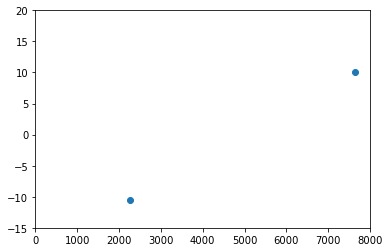

In [34]:
plt.scatter([fast_max, slow_max, lower_max], [fast_rotation*fast_distance, 
                                              slow_rotation*slow_distance, 
                                              lower_rotation*lower_distance])
plt.xlim([0,8000])
plt.ylim([-15,20])

In [15]:
bs = np.linspace(0, 0.5, 21)
taus = np.linspace(0, 6000, 21)
taus[0]=10

In [16]:
def run_latencies(val_array, val_str, ee, ii):

    latencies = np.zeros((len(val_array),2))
    
    for i, value in enumerate(val_array):
        
        params={'I_e': ee, 'I_i': ii, 'b': 0.25, 'end_t': 25*1000, 'mu_a': 0.4, 'beta_a': 10, 'n': 256, 'tau_a': 200}
        
        ps = setParams(params)
        
        ps[val_str] = value
        
        fps = computeFPs(ps)
        stab = checkFixPtsStability(fps, ps)
        
        k=np.linspace(-3,3,51)
        
        a_ee, a_ei, a_ie, a_ii = a_jkValues(fps[-1], ps)
        
        print('fixed points %s ' %str(fps))
        print('with (mass) stability %s'  %str(stab))
        
        fp = fps[0]
        
        ue, ui = c1d.run(ps, itype='inte_adaptation', fp=fp)
        
        duration = 10
        dur_steps = int(duration * (1/ps.dt) * 1000)
        signal = hilbert_trafo_nd(ue[-dur_steps:,:], axis=0)
        phases = inst_phase(signal)
        
        phases_cut = phases[-80000:]
        len(phases_cut.T), len(phases_cut)
        phases_cut.T[0]
        
        phase_latencies = np.zeros(len(phases_cut.T))
    
        for idx, node in enumerate(phases_cut.T):
            complex_vector = np.exp(1j * node)
            
            # Extract real and imaginary components of the complex vectors
            real_part = np.real(complex_vector)
            imaginary_part = np.imag(complex_vector)
            
            how_many_time_steps = getSwitchIndex(imaginary_part)
            #print(how_many_time_steps[0])
            phase_latencies[idx] = how_many_time_steps[0]
            
        rotation = rotation_in_latency(phase_latencies)
        amount_of_nodes = count_nodes_for_descent(phase_latencies, rotation)
        amount_time_steps = phase_latencies[np.argmax(phase_latencies)]
        
        latencies[i] = [amount_time_steps, amount_of_nodes]
        
    return latencies

In [17]:
b_lats = run_latencies(bs, 'b', 0.1, -0.55)

fixed points [[0.28034812 0.45602349]] 
with (mass) stability [0]
fixed points [[0.27832267 0.45210743]] 
with (mass) stability [0]
fixed points [[0.27635886 0.44831321]] 
with (mass) stability [0]
fixed points [[0.27445285 0.44463341]] 
with (mass) stability [0]
fixed points [[0.27260118 0.44106126]] 
with (mass) stability [0]
fixed points [[0.27080069 0.4375906 ]] 
with (mass) stability [0]
fixed points [[0.26904848 0.43421579]] 
with (mass) stability [0]
fixed points [[0.2673419  0.43093165]] 
with (mass) stability [0]
fixed points [[0.26567852 0.42773341]] 
with (mass) stability [0]
fixed points [[0.26405609 0.42461668]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26092598 0.41861183]] 
with (mass) stability [0]
fixed points [[0.25941461 0.41571645]] 
with (mass) stability [0]
fixed points [[0.25793679 0.41288803]] 
with (mass) stability [0]
fixed points [[0.25649099 0.41012356]] 
with (mass) stability [0]
fixed poin

In [18]:
tau_lats = run_latencies(taus, 'tau_a', 0.1, -0.55)

fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed points [[0.26247255 0.42157741]] 
with (mass) stability [0]
fixed poin

b:  [1.1785e+04 1.0000e+00]
b:  [20.  0.]
b:  [24.  0.]
b:  [49.  0.]
b:  [59.  0.]
b:  [21.  0.]
b:  [28.  0.]
b:  [44.  0.]
b:  [37.  0.]
b:  [45.  0.]
b:  [22.  0.]
b:  [47.  0.]
b:  [5. 0.]
b:  [1087.   21.]
b:  [1028.   21.]
b:  [988.  21.]
b:  [980.  21.]
b:  [940.  21.]
b:  [909.  21.]
b:  [895.  21.]
b:  [865.  21.]
tau:  [18.  0.]
tau:  [30.  0.]
tau:  [38.  0.]
tau:  [23.  0.]
tau:  [3. 0.]
tau:  [31.  0.]
tau:  [7. 0.]
tau:  [33.  0.]
tau:  [9. 0.]
tau:  [33.  0.]
tau:  [7. 0.]
tau:  [29.  0.]
tau:  [49.  0.]
tau:  [17.  0.]
tau:  [31.  0.]
tau:  [42.  0.]
tau:  [48.  0.]
tau:  [49.  0.]
tau:  [45.  0.]
tau:  [36.  0.]
tau:  [20.  0.]


(-1.0, 22.0)

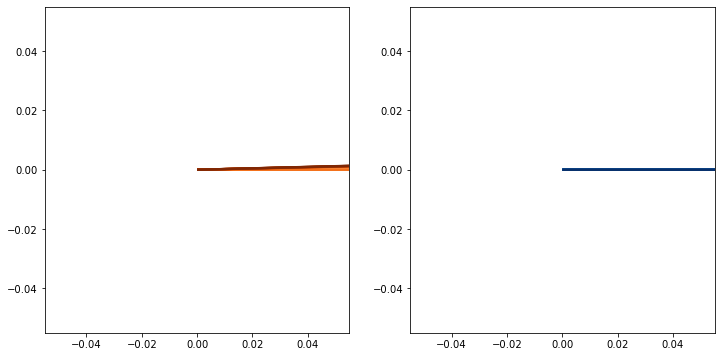

In [20]:
from matplotlib import cm

colors_b = cm.get_cmap('Oranges', len(bs))
colors_tau = cm.get_cmap('Blues', len(taus))

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))
for ind, pair in enumerate(b_lats):
    print('b: ', pair)
    ax0.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, color=colors_b(ind))
    
for ind, pair in enumerate(tau_lats):
    print('tau: ', pair)
    ax1.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, color=colors_tau(ind))
    

# Set axis limits based on the vectors
ax.set_xlim([-1, np.max(tau_lats[:,0])+1])
ax.set_ylim([-1, np.max(b_lats[:,1])+1])

In [21]:
b_df = pd.DataFrame(b_lats, index=bs, columns=['#time_steps', '#nodes'])
b_df.to_csv('phase_lats/ee01_ii_minus055_b.csv')

In [22]:
tau_df = pd.DataFrame(tau_lats, index=taus, columns=['#time_steps', '#nodes'])
tau_df.to_csv('phase_lats/ee01_ii_minus055_tau.csv')